# Penalized Cox_hazard proportional models

In [11]:
pip install -r requeriments_surv.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 9.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install --upgrade pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import json
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

%matplotlib inline

from pysurv_utils import *

import torch
import torch.optim as optim

from lifelines.utils import concordance_index
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sklearn import set_config
from lifelines.statistics import logrank_test
from torchsurv.loss.cox import neg_partial_log_likelihood
from torchsurv.loss.weibull import neg_log_likelihood

# Set experiment parameters

In [93]:
# Directoy params template
with open('coxnet_setup.json', 'r') as f:
    params = json.load(f)
    
params['tp']="tp1"
base_directory = '/app/Data/_Brain/Radiology/_Adult/_Glioma/'
params['out_folder']="_Survival_prediction_Baseline"

# Cross validation set up
params['train_ids']=[1,2,3,4]
params['test_ids']=[0]
params['subsampling_test']=True
params['val_fraction']=0.15
params['random_state']=1
params['n_splits']=10

# hold out validation
params['run_test']=True
params['var_threshold']=0.1

# feature familiy
features=["feat12"]
mri_modalities=["T1c"]
rois=["RoI1"]
non_modality_feature=False

# Constant parameters accross models
LEARNING_RATE = 1e-4
epochs = 100
verbose=0

# Training and validation losses
train_losses = []
val_losses = []

n_bootstraps = 1000
bootstrap_scores = []
null_c_indices = []

### **Loop for features /modalities/ habitats (Rois)** 

In [94]:
def cox_loss(log_hazard, event, time):
    order = torch.argsort(time, descending=True)
    log_hazard = log_hazard[order].squeeze()  
    event = event[order]  

    risk_sum = torch.cumsum(torch.exp(log_hazard), dim=0)
    log_likelihood = log_hazard - torch.log(risk_sum)  

    return -torch.sum(log_likelihood * event) / event.sum() 

In [95]:
def plot_losses(train_losses, val_losses, threshold, title="Loss",out_folder=None):
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title(title)
    plt.legend()
    
    if out_folder:
        os.makedirs(out_folder, exist_ok=True)  
        plot_path = os.path.join(out_folder + f"_loss_plot.png")
        plt.savefig(plot_path, dpi=300)
        print(f"Plot saved to: {plot_path}")
    plt.show()
    

In [96]:
from sksurv.metrics import concordance_index_censored

def Performance_metrics(X_test, Y_test, risk_scores, test=False, risk_threshold=None):
    c_index = concordance_index_censored(
        Y_test['Event_outcome.tdm'].values,
        Y_test['Survival_time.tdm'].values,
        risk_scores
    )[0]
    
    
    return c_index


In [97]:
def plot_km_survival_curves(title, event, time, risk_scores, threshold, out_folder):
    event = event.astype(bool)

    low_risk = risk_scores <= threshold
    high_risk = risk_scores > threshold

    # Plot Kaplan-Meier curve for Low Risk group
    time_low, survival_prob_low = kaplan_meier_estimator(event[low_risk], time[low_risk])
    plt.step(time_low, survival_prob_low, where="post", label="Low Risk", color="green")

    # Plot Kaplan-Meier curve for High Risk group
    time_high, survival_prob_high = kaplan_meier_estimator(event[high_risk], time[high_risk])
    plt.step(time_high, survival_prob_high, where="post", label="High Risk", color="red")

    plt.fill_between(time_low, survival_prob_low, step="post", color="green", alpha=0.1)
    plt.fill_between(time_high, survival_prob_high, step="post", color="red", alpha=0.1)

    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.title(f"Kaplan-Meier Survival Curve for {title}")
    plt.grid(True)
    plot_path = os.path.join(out_folder + f"{title}_loss_plot.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()


# Write a performance summary across experiments


>>>>>>>>>>>>>>>>>>>>>>>>>>> Data Loader


Regression method .... coxnet
Experiment folder .... _Survival_prediction_Baseline
Main out folder   .... UCSF-PDGM
Hold out set      .... UCSF-PDGM
Training_set      .... LUMIERE_CCF_IVYGAP_xCures
MRI modality      .... T1c
Tumor habitat     .... Edema
Feature familily   ... TextureBioM
coxnet settings
Variance threshold ... 0.1
lambda_L1 ratios   ... 1
n_alphas coeff     ... 10
max num iters      ... 10
alpha_min ration   ... 0.01
['/app/Data/_Brain/Radiology/_Adult/_Glioma/UCSF-PDGM/Feature_extraction/Feature_matrix/Baseline/UCSF-PDGM_T1c_Edema_TextureBioM_pp2_annots.csv', '/app/Data/_Brain/Radiology/_Adult/_Glioma/LUMIERE/Feature_extraction/Feature_matrix/Baseline/LUMIERE_T1c_Edema_TextureBioM_pp2_annots.csv', '/app/Data/_Brain/Radiology/_Adult/_Glioma/CCF/Feature_extraction/Feature_matrix/Baseline/CCF_T1c_Edema_TextureBioM_pp2_annots.csv', '/app/Data/_Brain/Radiology/_Adult/_Glioma/IVYGAP/Feature_extraction/Feature_matrix/Baseline/IVYGAP_

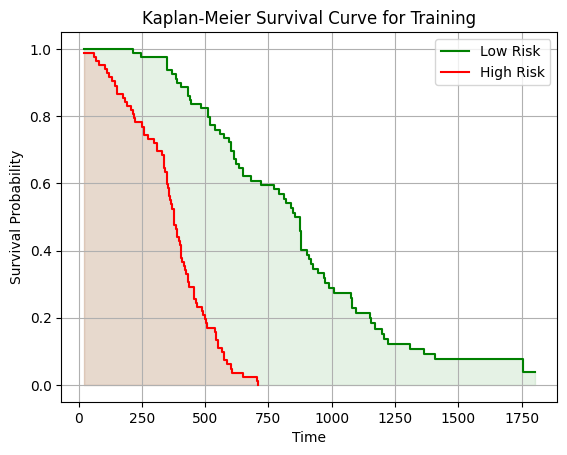

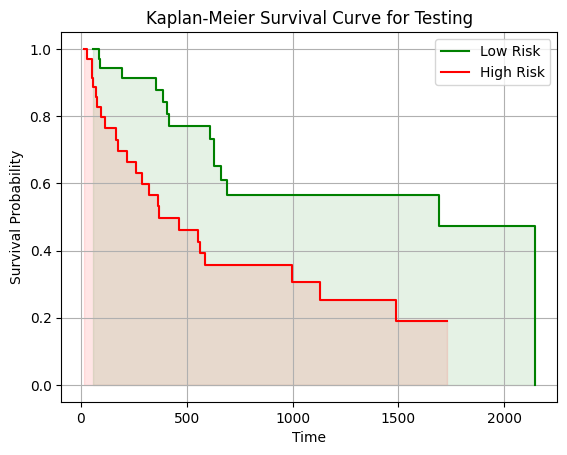

Plot saved to: /app/Data/_Brain/Radiology/_Adult/_Glioma/UCSF-PDGM/_Survival_prediction_Baseline/training_LUMIERE_CCF_IVYGAP_xCures/Edema_TextureBioM/DeepSurv_UCSF-PDGM_T1c_varThres_0.1_loss_plot.png


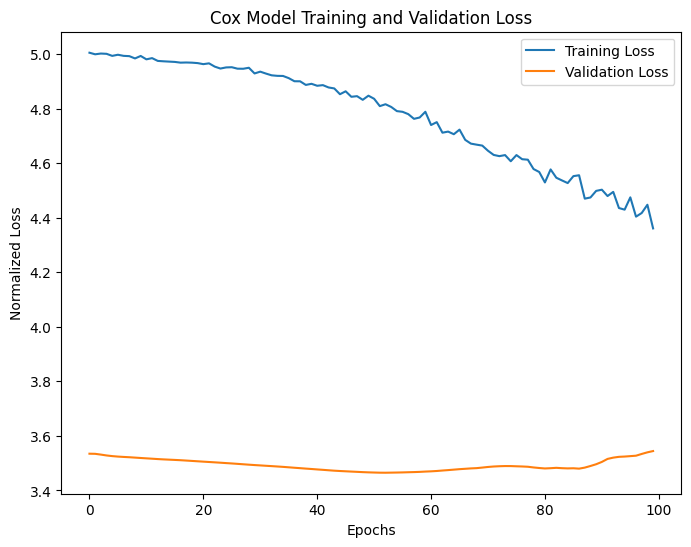

Concordance Index: 0.6693333333333333
C-index p-value: 0.009


In [98]:
for feat in features:
    params['feature']=feat

    for mri_mod in mri_modalities:
        params['mri_mod']=mri_mod

        for roi in rois:
            params['habitat']=roi

            DataLoader = DataSurvLoader(base_directory)
            DataLoader.setup_logger(**params) 
            output_base = DataLoader.FileTags(**params)
            csv_paths   = DataLoader.get_annotated_csv_paths(**params, non_modality=non_modality_feature) 
            print(csv_paths)
            train_data_df, nan_idx = DataLoader.load_annotated_featuremat(csv_paths,train_mat=True, **params)
            test_df, _ = DataLoader.load_annotated_featuremat(csv_paths, nan_columns_index=nan_idx , **params)

            if test_df.isnull().any().any():
                print(f"\n>>>>>>>>>>>>>>>>> {mri_mod}, {roi} still contains NaN Values after nan removal by training index")
                continue

            data_annots, Train_Val_Test_IDs = DataLoader.survival_annots(train_data_df, test_df)

            print(f"\n>>>>>>>>>>>>>>>>>>> training set ")
            Ytrain=data_annots[0] # first index for training
            Xtrain=DataLoader.load_featuremat(train_data_df,**params)
            Xtrain_selected, variance_selected = DataLoader.Varthreshold(Xtrain,train_mat=True)
            Ytest=data_annots[1]
            Xtest=DataLoader.load_featuremat(test_df,**params)
            Xtest_selected, _ = DataLoader.Varthreshold(Xtest,selected_features=variance_selected)
            
            
            # Convert to torch tensors
            X_train_tensor = torch.tensor(Xtrain_selected.values, dtype=torch.float32)
            X_val_tensor = torch.tensor(Xtest_selected.values, dtype=torch.float32)
            event_tensor = torch.tensor(np.array(Ytrain['Event_outcome.tdm']).copy(), dtype=torch.float32)
            time_tensor = torch.tensor(np.array(Ytrain['Survival_time.tdm']).copy(), dtype=torch.float32)
            val_event_tensor = torch.tensor(np.array(Ytest['Event_outcome.tdm']).copy(), dtype=torch.float32)
            val_time_tensor = torch.tensor(np.array(Ytest['Survival_time.tdm']).copy(), dtype=torch.float32)


            cox_model = torch.nn.Sequential(
            torch.nn.BatchNorm1d(X_train_tensor.shape[1]),
            torch.nn.Linear(X_train_tensor.shape[1], 128),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 1)
            )
            optimizer = optim.Adam(cox_model.parameters(), lr=LEARNING_RATE)
            
            for epoch in range(epochs):
                optimizer.zero_grad()  # Clear gradients
            
                # Forward pass on training data
                train_log_hazard = cox_model(X_train_tensor)
                #train_loss = cox_loss(train_log_hazard, event_tensor, time_tensor)
                train_loss = neg_partial_log_likelihood(train_log_hazard, event_tensor, time_tensor)
                
                # Backward pass and optimization
                train_loss.backward()
                optimizer.step()
                
                # Store training loss
                train_losses.append(train_loss.item())
            
                # Validation pass (without gradient tracking)
                with torch.no_grad():
                    cox_model.eval()  # Set to evaluation mode
                    val_log_hazard = cox_model(X_val_tensor)
                    #val_loss = cox_loss(train_log_hazard, event_tensor, time_tensor)
                    val_loss = neg_partial_log_likelihood(val_log_hazard, val_event_tensor, val_time_tensor)
                    val_losses.append(val_loss.item())
                    cox_model.train()  # Reset to training mode
                if verbose:
                    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
        
            if params['run_test']:
                
                train_risk_scores = train_log_hazard.detach().numpy().flatten()
                train_threshold=np.median(train_log_hazard.detach().numpy())
                plot_km_survival_curves("Training", event_tensor.numpy(), time_tensor.numpy(),train_risk_scores,train_threshold,output_base)

                val_risk_scores = val_log_hazard.detach().numpy().flatten()
                val_threshold=np.median(val_log_hazard.detach().numpy())
                plot_km_survival_curves("Testing", val_event_tensor.numpy(), val_time_tensor.numpy(),val_risk_scores,val_threshold, output_base)
                
                plot_losses(train_losses, val_losses, val_threshold, "Cox Model Training and Validation Loss", output_base)

                predicted_risk = -cox_model(X_val_tensor).detach().numpy()  # Convert log hazards to risk scores
                c_index = concordance_index(val_time_tensor.numpy(), predicted_risk, val_event_tensor.numpy())
                print("Concordance Index:", c_index)

                for _ in range(1000):
                    shuffled_event = np.random.permutation(val_event_tensor.numpy())
                    null_c_index = concordance_index(val_time_tensor.numpy(), predicted_risk, shuffled_event)
                    null_c_indices.append(null_c_index)
                
                # Computing p-value based on observed C-index compared to null distribution
                p_value = np.mean([1 if x >= c_index else 0 for x in null_c_indices])
                print("C-index p-value:", p_value)


In [99]:
print(type(val_log_hazard))
print(type(val_event_tensor))
print(type(val_time_tensor))
val_log_tensor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


NameError: name 'val_log_tensor' is not defined